<a href="https://www.kaggle.com/code/tanavbajaj/movie-reviews-sentiment-analysis?scriptVersionId=136177505" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Utilities
import re
import pickle
import numpy as np
import pandas as pd

# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
dataset = pd.read_csv("../input/imdb-movie-ratings-sentiment-analysis/movie.csv")

In [4]:
dataset.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


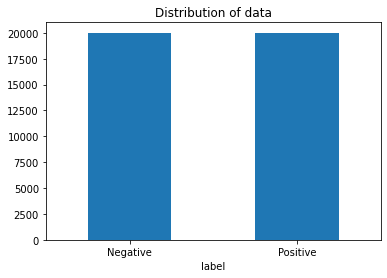

In [5]:
ax = dataset.groupby('label').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [6]:
contractions = pd.read_csv('../input/contractions/contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
linebreaks        = "<br /><br />"
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_reviews(review):

    review = review.lower()

    review = re.sub(linebreaks," ",review)
    # Replace 3 or more consecutive letters by 2 letter.
    review = re.sub(sequencePattern, seqReplacePattern, review)

    # Replace all emojis.
    review = re.sub(r'<3', '<heart>', review)
    review = re.sub(smileemoji, '<smile>', review)
    review = re.sub(sademoji, '<sadface>', review)
    review = re.sub(neutralemoji, '<neutralface>', review)
    review = re.sub(lolemoji, '<lolface>', review)

    for contraction, replacement in contractions_dict.items():
        review = review.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    review = re.sub(alphaPattern, ' ', review)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    review = re.sub(r'/', ' / ', review)
    return review

In [7]:
%%time
dataset['cleaned_review'] = dataset.text.apply(preprocess_reviews)

CPU times: user 19.7 s, sys: 63.6 ms, total: 19.8 s
Wall time: 19.8 s


In [8]:
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english')) 
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [9]:
dataset["cleaned_review"][0]

'i grew up  b  1965  watching and loving the thunderbirds  all my mates at school watched  we played  thunderbirds  before school  during lunch and after school  we all wanted to be virgil or scott  no one wanted to be alan  counting down from 5 became an art form  i took my children to see the movie hoping they would get a glimpse of what i loved as a child  how bitterly disappointing  the only high point was the snappy theme tune  not that it could compare with the original score of the thunderbirds  thankfully early saturday mornings one television channel still plays reruns of the series gerry anderson and his wife created  jonatha frakes should hand in his directors chair  his version was completely hopeless  a waste of film  utter rubbish  a cgi remake may be acceptable but replacing marionettes with homo sapiens subsp  sapiens was a huge error of judgment '

In [10]:
# j = 0
for i in range(len(dataset)):
    lis = []
    for words in dataset["cleaned_review"][i].split():
        if words not in stop_words:
            words = lemmatizer.lemmatize(words)
            lis.append(words)
    dataset["cleaned_review"][i] = " ".join(lis)

#     j += 1
#     if j > 0:
#         break

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
print(dataset["cleaned_review"][69])

kennan ivory wayans funny low dirty shame see one one worst done steven seagal help much start odd religious killing make much sense jim campbell keenan surprised see new partner waiting work side crack case jack cole seem everyone think jackis ex wife killed one ritual killing end making suspect well thing movie smoke past cia involvement trying normal cop steven dress like western movie prayer beeds top make thing little confusing


In [12]:
data_pos = dataset[dataset["label"]==1]["cleaned_review"]
data_neg = dataset[dataset["label"]==0]["cleaned_review"]

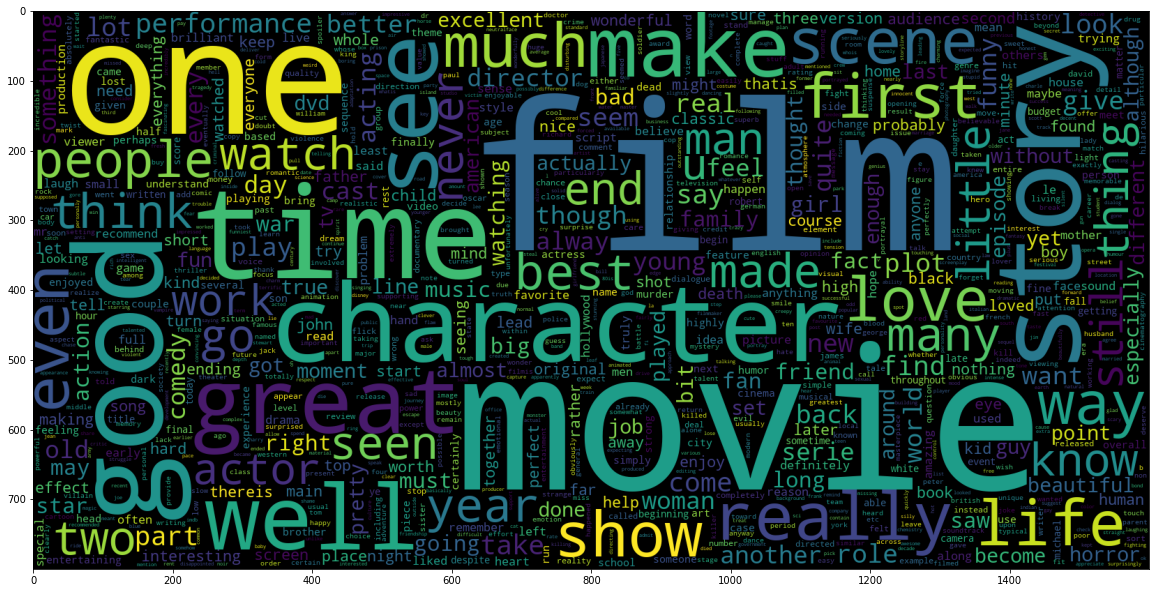

In [13]:
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

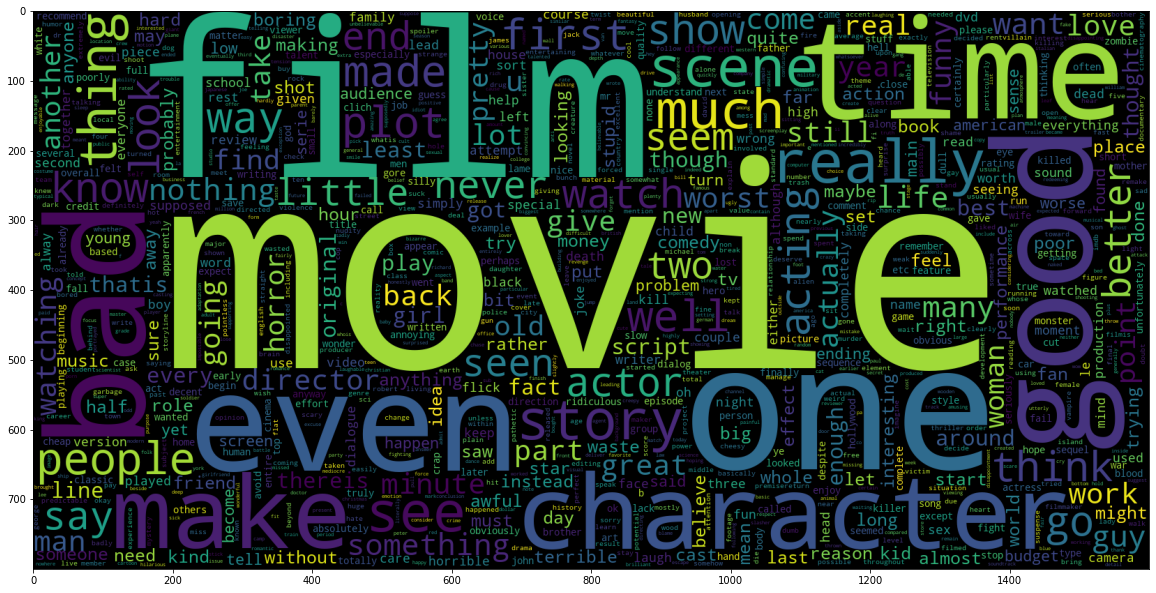

In [14]:
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [15]:
from sklearn.model_selection import train_test_split


In [16]:
X_data, y_data = np.array(dataset['cleaned_review']), np.array(dataset['label'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.05, random_state = 0)
print('Data Split done.')


Data Split done.


In [17]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [18]:
# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 32781


In [19]:
input_length = 750

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
vocab_length = 35000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 35000


In [21]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (38000, 750)
X_test.shape : (2000, 750)


In [22]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (35000, 100)


In [23]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import SimpleRNN,Dense,Activation,Bidirectional,GlobalMaxPool1D
from keras.utils.vis_utils import plot_model

In [24]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        SimpleRNN(100,input_shape = (vocab_length,input_length),return_sequences=False,activation="LeakyReLU"),
        Dense(32,activation="relu"),
        Dense(1,activation="sigmoid"),
    ],
     name="Sentiment_Model")
    return model

In [25]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 750, 100)          3500000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100)               20100     
_________________________________________________________________
dense (Dense)                (None, 32)                3232      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 3,523,365
Trainable params: 23,365
Non-trainable params: 3,500,000
_________________________________________________________________


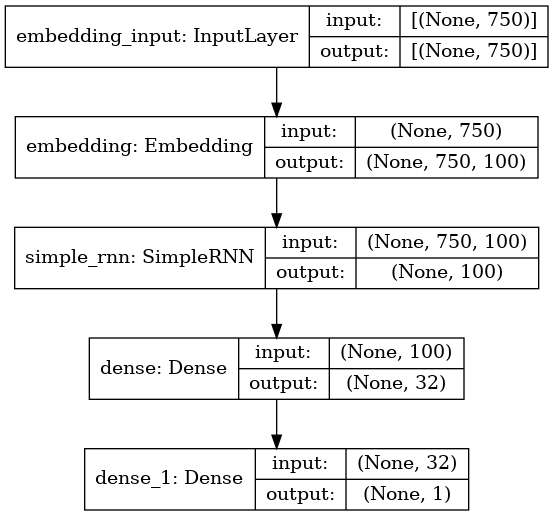

In [26]:
plot_model(training_model, "RNN.png", show_shapes=True)

In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [28]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=20,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/20
34/34 [==============================] - 24s 636ms/step - loss: 0.6448 - accuracy: 0.6426 - val_loss: 0.5258 - val_accuracy: 0.7292
Epoch 2/20
34/34 [==============================] - 20s 584ms/step - loss: 0.5620 - accuracy: 0.7370 - val_loss: 0.7748 - val_accuracy: 0.6174
Epoch 3/20
34/34 [==============================] - 20s 593ms/step - loss: 0.6444 - accuracy: 0.6456 - val_loss: 0.5872 - val_accuracy: 0.6847
Epoch 4/20
34/34 [==============================] - 21s 614ms/step - loss: 0.5646 - accuracy: 0.7027 - val_loss: 0.5626 - val_accuracy: 0.7042
Epoch 5/20
34/34 [==============================] - 21s 616ms/step - loss: 0.5410 - accuracy: 0.7218 - val_loss: 0.5391 - val_accuracy: 0.7247
Epoch 6/20
34/34 [==============================] - 21s 617ms/step - loss: 0.5135 - accuracy: 0.7412 - val_loss: 0.4937 - val_accuracy: 0.7566
Epoch 7/20
34/34 [==============================] - 21s 604ms/step - loss: 0.4290 - accuracy: 0.8038 - val_loss: 0.3774 - val_accuracy: 0.8374

### LSTM


In [30]:
from tensorflow.keras.layers import LSTM, Dropout

In [31]:
def getModel2():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        LSTM(64,return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1,activation="sigmoid")
    ],
    name="Sentiment_Model_LSTM")
    return model

In [32]:
training_model2 = getModel2()
training_model2.summary()

Model: "Sentiment_Model_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 750, 100)          3500000   
_________________________________________________________________
lstm (LSTM)                  (None, 750, 64)           42240     
_________________________________________________________________
dropout (Dropout)            (None, 750, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,554,689
Trainable params: 54,689
Non-trainable params: 3,500,000
_______________________________

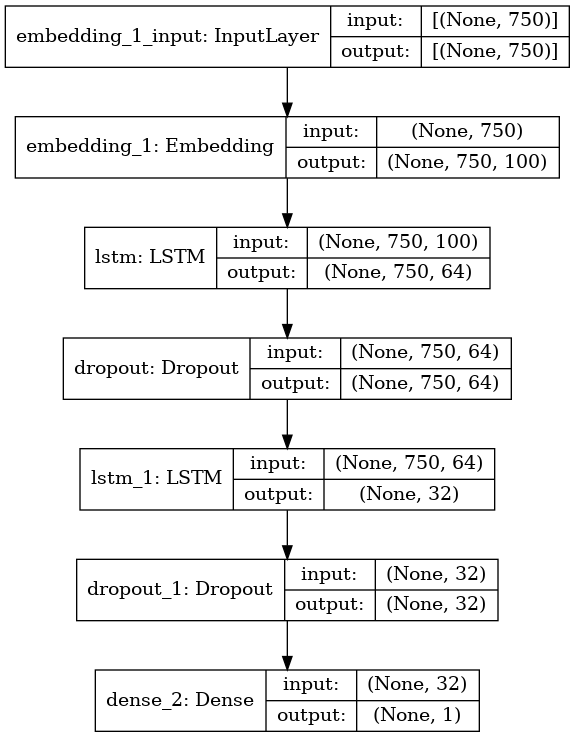

In [33]:
plot_model(training_model2, "LSTM.png", show_shapes=True)

In [34]:
training_model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
history2 = training_model2.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=20,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/20
34/34 [==============================] - 11s 203ms/step - loss: 0.5302 - accuracy: 0.7356 - val_loss: 0.3948 - val_accuracy: 0.8234
Epoch 2/20
34/34 [==============================] - 6s 185ms/step - loss: 0.3685 - accuracy: 0.8454 - val_loss: 0.3235 - val_accuracy: 0.8726
Epoch 3/20
34/34 [==============================] - 6s 186ms/step - loss: 0.3208 - accuracy: 0.8658 - val_loss: 0.3053 - val_accuracy: 0.8787
Epoch 4/20
34/34 [==============================] - 6s 186ms/step - loss: 0.3061 - accuracy: 0.8735 - val_loss: 0.2899 - val_accuracy: 0.8789
Epoch 5/20
34/34 [==============================] - 6s 188ms/step - loss: 0.2840 - accuracy: 0.8832 - val_loss: 0.2802 - val_accuracy: 0.8882
Epoch 6/20
34/34 [==============================] - 6s 184ms/step - loss: 0.2718 - accuracy: 0.8880 - val_loss: 0.2754 - val_accuracy: 0.8847
Epoch 7/20
34/34 [==============================] - 6s 182ms/step - loss: 0.2647 - accuracy: 0.8924 - val_loss: 0.2697 - val_accuracy: 0.8918
Epoch

### Bidirectional LSTM

In [36]:
def getModel3():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(35,return_sequences=True)),
        GlobalMaxPool1D(),
        Dense(40, activation="relu"),
        Dropout(0.5),
        Dense(20, activation="relu"),
        Dropout(0.5),
        Dense(1, activation="sigmoid"),
    ],
    name="Sentiment_Model_LSTM_Bidirectional")
    return model

In [37]:
training_model3 = getModel3()
training_model3.summary()

Model: "Sentiment_Model_LSTM_Bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 750, 100)          3500000   
_________________________________________________________________
bidirectional (Bidirectional (None, 750, 70)           38080     
_________________________________________________________________
global_max_pooling1d (Global (None, 70)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2840      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dropout_3 (Dropout)          (No

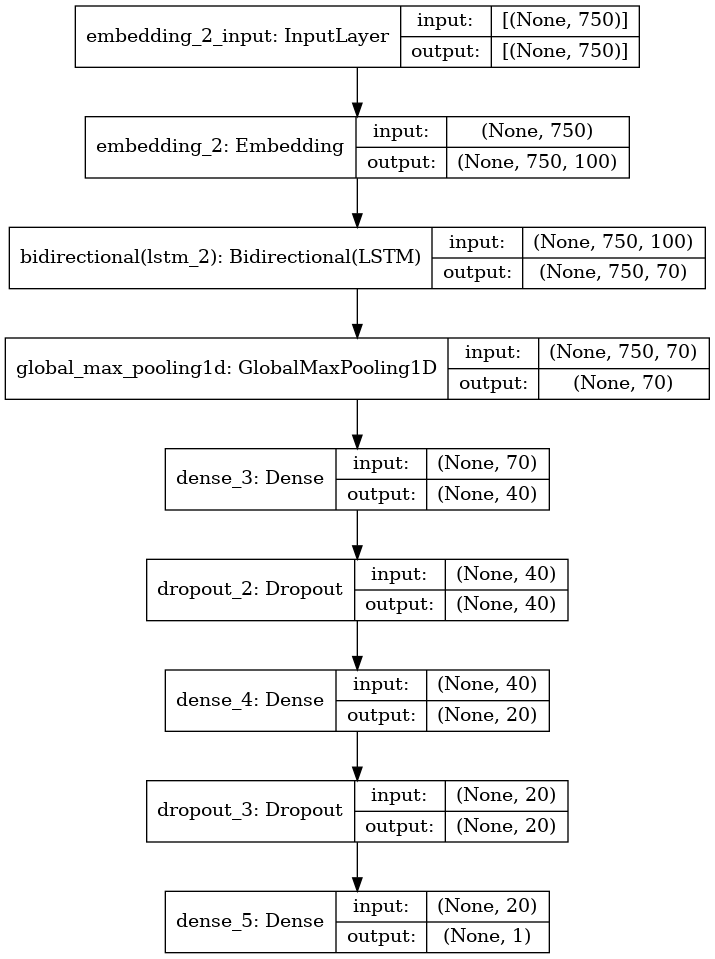

In [38]:
plot_model(training_model3, "LSTM_bidirectional.png", show_shapes=True)

In [39]:
training_model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
history3 = training_model3.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=20,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/20
34/34 [==============================] - 10s 214ms/step - loss: 0.6764 - accuracy: 0.5715 - val_loss: 0.5916 - val_accuracy: 0.7884
Epoch 2/20
34/34 [==============================] - 7s 195ms/step - loss: 0.5322 - accuracy: 0.7454 - val_loss: 0.3684 - val_accuracy: 0.8566
Epoch 3/20
34/34 [==============================] - 7s 195ms/step - loss: 0.4082 - accuracy: 0.8330 - val_loss: 0.3080 - val_accuracy: 0.8742
Epoch 4/20
34/34 [==============================] - 7s 198ms/step - loss: 0.3545 - accuracy: 0.8655 - val_loss: 0.2890 - val_accuracy: 0.8808
Epoch 5/20
34/34 [==============================] - 7s 194ms/step - loss: 0.3321 - accuracy: 0.8720 - val_loss: 0.2876 - val_accuracy: 0.8861
Epoch 6/20
34/34 [==============================] - 7s 195ms/step - loss: 0.3117 - accuracy: 0.8824 - val_loss: 0.2738 - val_accuracy: 0.8832
Epoch 7/20
34/34 [==============================] - 7s 195ms/step - loss: 0.2968 - accuracy: 0.8907 - val_loss: 0.2675 - val_accuracy: 0.8889
Epoch

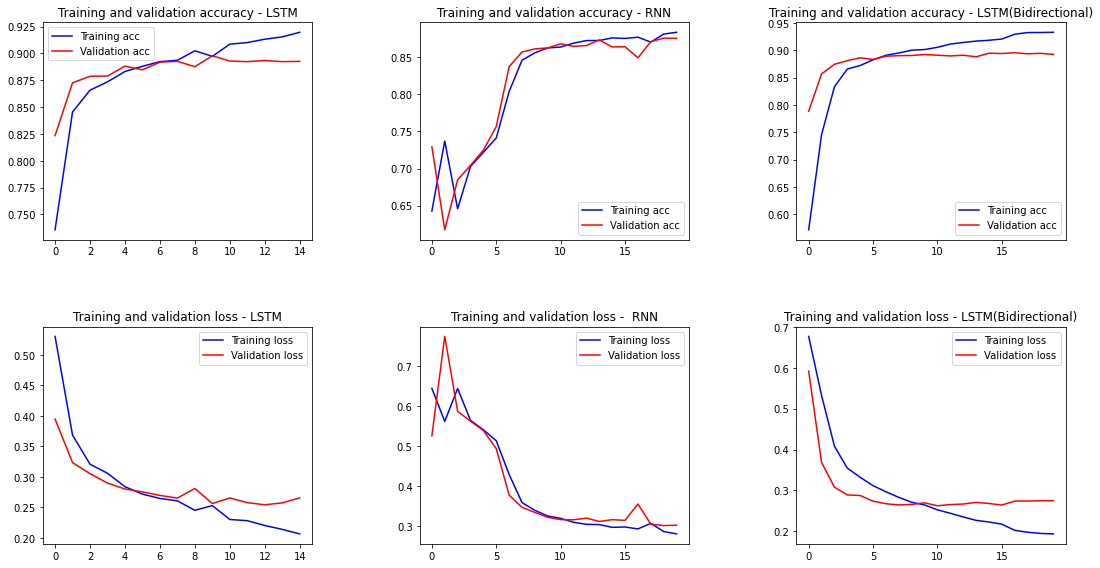

In [41]:

figure , axis = plt.subplots(2,3,figsize=(15,8))
# figure.add_gridspec(2, 2, hspace=10, wspace=10)
# plt.figure(figsize=(8, 6))
acc2,  val_acc2  = history2.history['accuracy'], history2.history['val_accuracy']
loss2, val_loss2 = history2.history['loss'], history2.history['val_loss']
epochs2 = range(len(acc2))
axis[0,0].plot(epochs2, acc2, 'b', label='Training acc')
axis[0,0].plot(epochs2, val_acc2, 'r', label='Validation acc')
axis[0,0].set_title('Training and validation accuracy - LSTM')
axis[0,0].legend()

# plt.figure()

axis[1,0].plot(epochs2, loss2, 'b', label='Training loss')
axis[1,0].plot(epochs2, val_loss2, 'r', label='Validation loss')
axis[1,0].set_title('Training and validation loss - LSTM')
axis[1,0].legend()

# plt.show()

acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

axis[0,1].plot(epochs, acc, 'b', label='Training acc')
axis[0,1].plot(epochs, val_acc, 'r', label='Validation acc')
axis[0,1].set_title('Training and validation accuracy - RNN')
axis[0,1].legend()

# plt.figure()

axis[1,1].plot(epochs, loss, 'b', label='Training loss')
axis[1,1].plot(epochs, val_loss, 'r', label='Validation loss')
axis[1,1].set_title('Training and validation loss -  RNN')
axis[1,1].legend()

acc3,  val_acc3  = history3.history['accuracy'], history3.history['val_accuracy']
loss3, val_loss3 = history3.history['loss'], history3.history['val_loss']
epochs3 = range(len(acc3))
axis[0,2].plot(epochs3, acc3, 'b', label='Training acc')
axis[0,2].plot(epochs3, val_acc3, 'r', label='Validation acc')
axis[0,2].set_title('Training and validation accuracy - LSTM(Bidirectional)')
axis[0,2].legend()

# plt.figure()

axis[1,2].plot(epochs3, loss3, 'b', label='Training loss')
axis[1,2].plot(epochs3, val_loss3, 'r', label='Validation loss')
axis[1,2].set_title('Training and validation loss - LSTM(Bidirectional)')
axis[1,2].legend()

# plt.figure(figsize=(100,100))
figure.tight_layout()
plt.subplots_adjust(wspace=0.4, 
                    hspace=0.4)

plt.show()


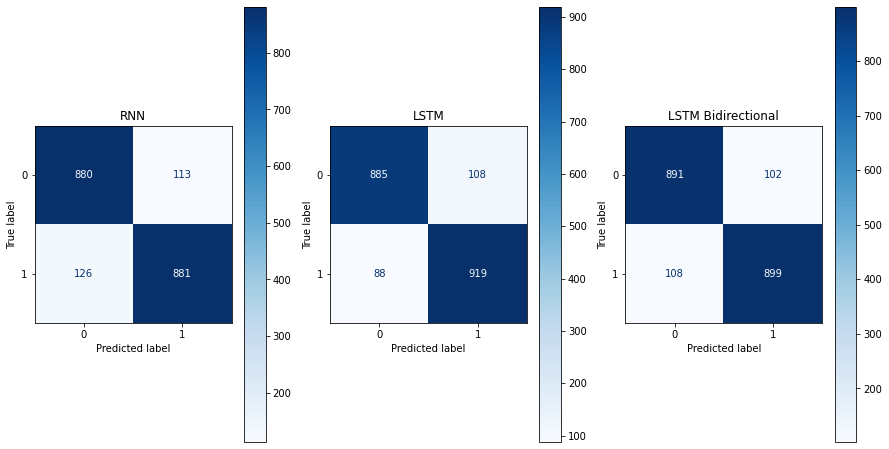

In [42]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay , confusion_matrix

# def ConfusionMatrix(y_pred, y_test):
#     # Compute and plot the Confusion matrix
#     cf_matrix = confusion_matrix(y_test, y_pred)



#     sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
#                 xticklabels = categories, yticklabels = categories)

#     plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
#     plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
def get_labels(y_pred,y_test):
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    return labels

# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)
y_pred2 = training_model2.predict(X_test)
y_pred3 = training_model3.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)
y_pred2 = np.where(y_pred2>=0.5, 1, 0)
y_pred3 = np.where(y_pred3>=0.5, 1, 0)

l1 = get_labels(y_pred,y_test)
l2 = get_labels(y_pred2,y_test)
l3 = get_labels(y_pred3,y_test)

# Printing out the Evaluation metrics. 
fig, ax = plt.subplots(1,3,figsize=(15,8))
ax[0].set_title("RNN")
ax[1].set_title("LSTM")
ax[2].set_title("LSTM Bidirectional")

ConfusionMatrixDisplay.from_predictions(y_test,y_pred,cmap="Blues" ,ax = ax[0])
ConfusionMatrixDisplay.from_predictions(y_test,y_pred2,cmap="Blues",ax = ax[1])
ConfusionMatrixDisplay.from_predictions(y_test,y_pred3,cmap="Blues" ,ax = ax[2])

plt.show()




In [43]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred2))
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       993
           1       0.89      0.87      0.88      1007

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       993
           1       0.89      0.91      0.90      1007

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       993
           1       0.90      0.89      0.90      1007

    accuracy                           0.90      2000
   macro avg       0.89      0.90      0.89      2000
weighted avg       0.90      0.90      0.90      2000



In [44]:
statement = ["worst day of my life"]
print(statement)
for i in range(len(statement)):
    listr = []
    statement[i] = preprocess_reviews(statement[i])
    for word in statement[i].split():
        if word.lower() not in stop_words:
            listr.append(word)
    statement[i] = " ".join(listr)
print(statement)

['worst day of my life']
['worst day life']


In [45]:
statement = pad_sequences(tokenizer.texts_to_sequences(statement) , maxlen=input_length)
statement.shape
pred = training_model.predict(statement)
pred = np.where(pred>=0.5, 1, 0)
pred2 = training_model2.predict(statement)
pred2 = np.where(pred>=0.5, 1, 0)
pred3 = training_model3.predict(statement)
pred3 = np.where(pred>=0.5, 1, 0)

In [46]:
print("RNN :" , pred)
print("LSTM :" , pred2)
print("LSTM Bidirectional :" , pred3)

RNN : [[0]]
LSTM : [[0]]
LSTM Bidirectional : [[0]]
